In [7]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Define file path and chunk size
file_path = "995,000_rows.csv"
chunksize = 10000

# Define your cleaning function
def clean_text(data):
    if not isinstance(data, str):  # Handle NaN values safely
        return ""
    data = data.lower()
    data = re.sub(r'\s+', " ", data)
    data = re.sub(r'\d{1,2}[./-]\d{1,2}[./-]\d{2,4}', "<DATE>", data)
    data = re.sub(r'(?:jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec).? \d{1,2},? \d{4}', "<DATE>", data)
    data = re.sub(r'\d{4}-\d{2}-\d{2}', "<DATE>", data)
    data = re.sub(r'[\w._%+-]+@[\w.-]+\.[a-zA-Z]{2,}', "<EMAIL>", data)
    data = re.sub(r'http[s]?://[^\s]+', "<URL>", data)
    data = re.sub(r'\d+(\.\d+)?', "<NUM>", data)
    return data

# Initialize stopwords and stemmer
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

# Define function to tokenize, remove stopwords, and stem
def tokenize_and_stem(text):
    tokens = word_tokenize(text)
    filtered_tokens = [ps.stem(word) for word in tokens if word.isalpha() and word not in stop_words]
    return filtered_tokens

# List of columns to clean (with clean_text)
columns_to_clean = [
    "id", "domain", "type", "url", "content", "title", "authors", "keywords", 
    "meta_keywords", "meta_description", "tags", "summary"
]

# Create empty DataFrame to collect processed chunks
preprocessed_data = []

# Process chunks
for chunk_number, chunk in enumerate(pd.read_csv(file_path, chunksize=chunksize, low_memory=False)):
    # Apply cleaning function to specified columns
    for col in columns_to_clean:
        if col in chunk.columns:
            chunk[col] = chunk[col].apply(clean_text)
    
    # Remove stopwords, tokenize, and stem only for 'content' column
    if 'content' in chunk.columns:
        chunk['content'] = chunk['content'].astype(str).apply(tokenize_and_stem)
    
    preprocessed_data.append(chunk)
    print(f"Processed chunk {chunk_number + 1}")

# Combine and save all cleaned data
final_df = pd.concat(preprocessed_data, ignore_index=True)
final_df.to_csv("cleaned_file.csv", index=False)
print("All done! Cleaned file saved as cleaned_file.csv")



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\emilv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\emilv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Processed chunk 1
Processed chunk 2
Processed chunk 3
Processed chunk 4
Processed chunk 5
Processed chunk 6
Processed chunk 7
Processed chunk 8
Processed chunk 9
Processed chunk 10
Processed chunk 11
Processed chunk 12
Processed chunk 13
Processed chunk 14
Processed chunk 15
Processed chunk 16
Processed chunk 17
Processed chunk 18
Processed chunk 19
Processed chunk 20
Processed chunk 21
Processed chunk 22
Processed chunk 23
Processed chunk 24
Processed chunk 25
Processed chunk 26
Processed chunk 27
Processed chunk 28
Processed chunk 29
Processed chunk 30
Processed chunk 31
Processed chunk 32
Processed chunk 33
Processed chunk 34
Processed chunk 35
Processed chunk 36
Processed chunk 37
Processed chunk 38
Processed chunk 39
Processed chunk 40
Processed chunk 41
Processed chunk 42
Processed chunk 43
Processed chunk 44
Processed chunk 45
Processed chunk 46
Processed chunk 47
Processed chunk 48
Processed chunk 49
Processed chunk 50
Processed chunk 51
Processed chunk 52
Processed chunk 53
Pr

Total rows processed: 995000

Missing values in metadata columns (count):
authors             442757
meta_keywords        38790
meta_description    525106
tags                764081
summary             995000
dtype: int64

Missing values in metadata columns (percentage):
authors              44.50
meta_keywords         3.90
meta_description     52.77
tags                 76.79
summary             100.00
dtype: float64

Domain distribution (top 10):
nytimes.com           176144
beforeitsnews.com      91468
dailykos.com           77640
express.co.uk          55983
nationalreview.com     37377
sputniknews.com        37229
abovetopsecret.com     27947
wikileaks.org          23699
www.newsmax.com        12688
www.ammoland.com       11129
dtype: int64

Total articles with 'error' in content: 81821

Content length statistics:
count    995000.000000
mean       2475.007124
std        3575.823014
min           2.000000
25%         587.000000
50%        1591.000000
75%        3176.000000
max     

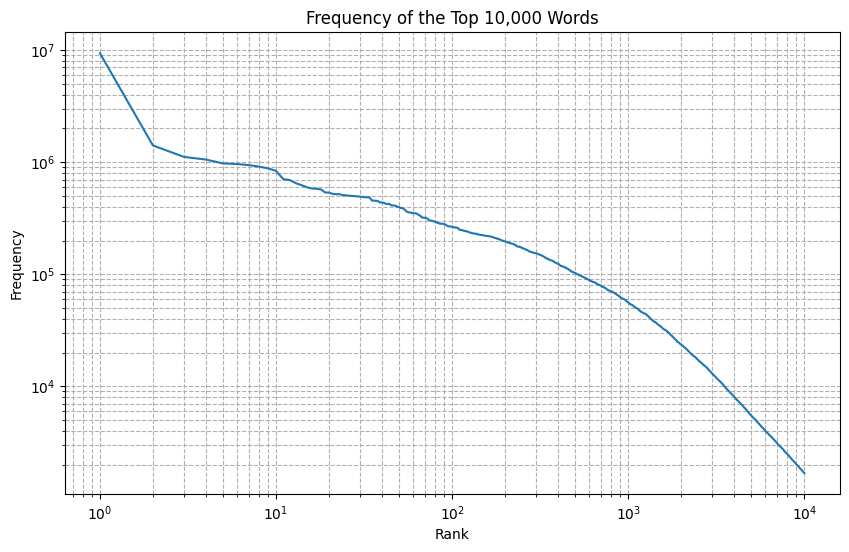

In [9]:
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt

cleaned_file = "cleaned_file.csv"
chunksize = 25000  

# Columns to analyze for missing metadata
metadata_cols = ['authors', 'meta_keywords', 'meta_description', 'tags', 'summary']

# Accumulators for initial observations
total_rows = 0
missing_counts_acc = None
domain_counts_acc = {}
error_count_acc = 0
content_lengths = []

# Accumulators for content analysis
total_urls = 0
total_dates = 0
total_numerics = 0
word_counter = Counter()

# Process the CSV in chunks
for chunk in pd.read_csv(cleaned_file, chunksize=chunksize, low_memory=False):
    total_rows += len(chunk)
    
    # Observation 1: Missing values for metadata columns 
    chunk_missing = chunk[metadata_cols].isnull().sum()
    if missing_counts_acc is None:
        missing_counts_acc = chunk_missing
    else:
        missing_counts_acc += chunk_missing

    # Observation 2: Domain distribution 
    chunk_domain_counts = chunk['domain'].value_counts()
    for domain, count in chunk_domain_counts.items():
        domain_counts_acc[domain] = domain_counts_acc.get(domain, 0) + count

    # Observation 3: Content Artifacts and Anomalies
    # Convert the 'content' column to string
    chunk['content'] = chunk['content'].astype(str)
    # Detect rows containing "error"
    error_mask = chunk['content'].str.contains(r"\berror\b", case=False, regex=True, na=False)
    error_count_acc += error_mask.sum()

    # Accumulate content lengths
    content_lengths.extend(chunk['content'].apply(len).tolist())
    
    # Counting URLs, dates, numeric values, and aggregating words
    # Inline regex patterns with (?i) for case-insensitive matching
    url_regex = r'(?i)https?://\S+'
    date_regex = r'(?i)\b(?:\d{1,2}[/-]\d{1,2}[/-]\d{2,4}|\d{4}-\d{2}-\d{2})\b'
    numeric_regex = r'\b\d+(?:\.\d+)?\b'
    word_regex = r'\w+'
    
    total_urls += chunk['content'].str.count(url_regex).sum()
    total_dates += chunk['content'].str.count(date_regex).sum()
    total_numerics += chunk['content'].str.count(numeric_regex).sum()
    
    # Aggregate word counts for the top frequent words
    combined_text = " ".join(chunk['content'].tolist())
    words = re.findall(word_regex, combined_text.lower())
    word_counter.update(words)

# Results after processing
print("Total rows processed:", total_rows)

print("\nMissing values in metadata columns (count):")
print(missing_counts_acc)
print("\nMissing values in metadata columns (percentage):")
print((missing_counts_acc / total_rows * 100).round(2))

print("\nDomain distribution (top 10):")
domain_series = pd.Series(domain_counts_acc).sort_values(ascending=False)
print(domain_series.head(10))

print("\nTotal articles with 'error' in content:", error_count_acc)

print("\nContent length statistics:")
print(pd.Series(content_lengths).describe())

# Additional content analysis results
print("\nTotal URLs found in content:", total_urls)
print("Total dates found in content:", total_dates)
print("Total numeric values found in content:", total_numerics)

# Top 100 most frequent words
top_100_words = word_counter.most_common(100)
print("\nTop 100 most frequent words:")
for word, count in top_100_words:
    print(f"{word}: {count}")

# Plot frequency of the top 10,000 most frequent words
top_10000 = word_counter.most_common(10000)
if top_10000:
    ranks = range(1, len(top_10000) + 1)
    frequencies = [freq for word, freq in top_10000]
    
    plt.figure(figsize=(10, 6))
    plt.plot(ranks, frequencies)
    plt.xlabel('Rank')
    plt.ylabel('Frequency')
    plt.title('Frequency of the Top 10,000 Words')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, which="both", ls="--")
    plt.show()
    
else:
    print("Not enough words to plot the top 10,000 frequencies.")

In [ ]:
from sklearn.model_selection import train_test_split
# Load the cleaned file
split_cleaned_file = pd.read_csv("cleaned_file.csv")
#Split dataset in 80% train and 10% test and 10% validation
X_train, X_rest, y_train, y_rest = train_test_split(split_cleaned_file, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)


#Print the shapes of the resulting datasets
print("Training data shape:", len(X_train))
print("Validation data shape:", len(X_val))
print("Testing data shape:", len(X_test))

C:\Users\emilv\AppData\Local\Temp\ipykernel_5860\1538483547.py:2: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  split_cleaned_file = pd.read_csv("måske_cleaned_file.csv")


Training data shape: 796000
Validation data shape: 99500
Testing data shape: 99500
